<a href="https://colab.research.google.com/github/kotireddys/masters_thesis/blob/main/Thesis5_SDF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🧩 Found 525 semantic tiles
🧵 Stitching semantic tiles into full map (resizing + decoding colors)...


100%|██████████| 525/525 [00:56<00:00,  9.36it/s]


✅ Stitched semantic map saved at: /content/drive/MyDrive/Thesis/Sensor_Datafusion/Fused/stitched_semantic_map.png
🎯 Detected classes in stitched semantic map: [0 2 4 7]
✅ Semantic safety map generated → shape: (112, 74)
📈 Computing terrain metrics...
✅ Flatness range: 0.000–1.000
✅ Roughness range: 0.000–1.000
✅ Fused safety map ready → shape: (112, 74)
✅ Fused safety map saved → /content/drive/MyDrive/Thesis/Sensor_Datafusion/Fused/fused_safety_map.tif


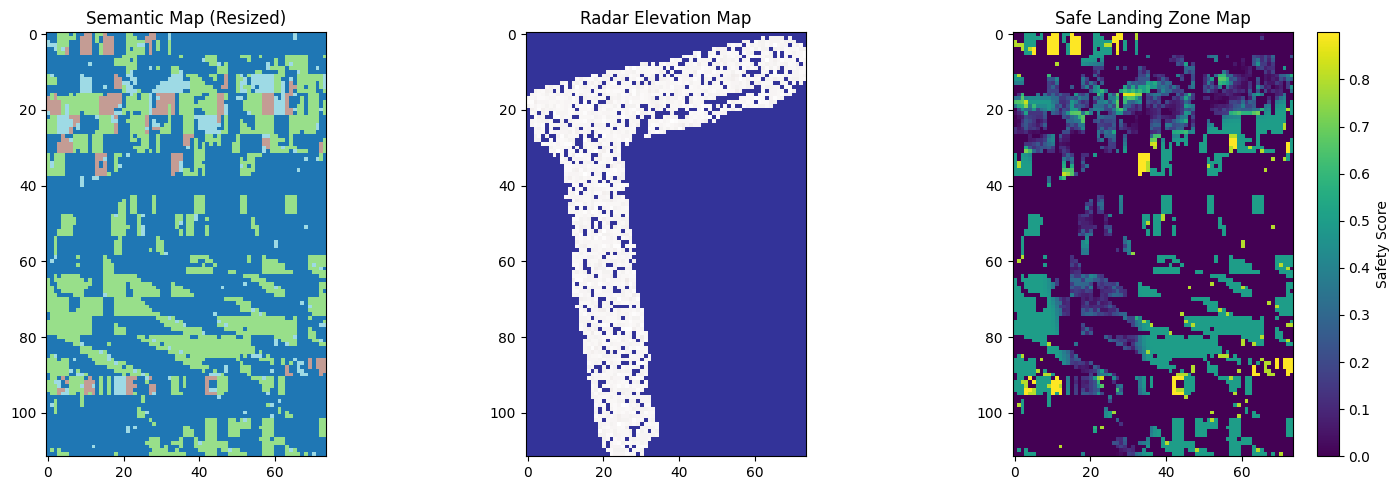

🎯 Fusion complete — Semantic + Radar Safe Landing Zone Map successfully generated!


In [ ]:
!pip install rasterio tqdm

import os
import cv2
import glob
import numpy as np
import rasterio
from tqdm import tqdm
import matplotlib.pyplot as plt

# -------------------- CONFIG --------------------
BASE_DIR = "/content/drive/MyDrive/Thesis/Semantic Segmentation/terrain_v3"
SEMANTIC_DIR = os.path.join(BASE_DIR, "results_colored")
RADAR_PATH = "/content/drive/MyDrive/Thesis/Synthetic Radar_Elevated_Map/simulated_radar_elevation.tif"
OUT_DIR = "/content/drive/MyDrive/Thesis/Sensor_Datafusion/Fused"
os.makedirs(OUT_DIR, exist_ok=True)

# -------------------- 1. COLOR → CLASS MAPPING --------------------
# Replace colors below with your actual color codes if they differ
COLOR_TO_CLASS = {
    (0, 0, 0): 0,          # background
    (255, 255, 0): 1,      # flat sand
    (0, 255, 0): 2,        # grassland
    (255, 0, 0): 3,        # obstacle
    (128, 128, 128): 4,    # parking lot
    (255, 128, 0): 5,      # pavement
    (128, 0, 128): 6,      # railway track
    (0, 0, 255): 7,        # road
    (255, 192, 203): 8,    # sand heaps
    (0, 128, 0): 9,        # trees
    (255, 255, 255): 10    # unknown
}

def rgb_to_class(img_rgb):
    """Convert RGB mask to class IDs (0–10)"""
    class_map = np.zeros(img_rgb.shape[:2], dtype=np.uint8)
    for color, cls_id in COLOR_TO_CLASS.items():
        mask = np.all(img_rgb == np.array(color, dtype=np.uint8), axis=-1)
        class_map[mask] = cls_id
    return class_map

# -------------------- 2. LOAD & STITCH SEMANTIC MASKS --------------------
semantic_tiles = sorted(glob.glob(os.path.join(SEMANTIC_DIR, '**', '*.png'), recursive=True))
print(f"🧩 Found {len(semantic_tiles)} semantic tiles")

cols, rows = 25, 21   # 25 × 21 = 525 tiles
tile_size = 512
stitched_semantic = np.zeros((rows * tile_size, cols * tile_size), dtype=np.uint8)

print("🧵 Stitching semantic tiles into full map (resizing + decoding colors)...")
for i, fname in enumerate(tqdm(semantic_tiles)):
    img = cv2.imread(fname)
    if img is None:
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (tile_size, tile_size), interpolation=cv2.INTER_NEAREST)
    class_mask = rgb_to_class(img)

    r, c = divmod(i, cols)
    stitched_semantic[
        r * tile_size:(r + 1) * tile_size,
        c * tile_size:(c + 1) * tile_size
    ] = class_mask

stitched_path = os.path.join(OUT_DIR, "stitched_semantic_map.png")
cv2.imwrite(stitched_path, stitched_semantic)
print(f"✅ Stitched semantic map saved at: {stitched_path}")

# -------------------- 3. LOAD RADAR ELEVATION MAP --------------------
with rasterio.open(RADAR_PATH) as src:
    radar = src.read(1).astype(np.float32)
    radar_meta = src.meta.copy()

radar_h, radar_w = radar.shape
semantic_resized = cv2.resize(stitched_semantic, (radar_w, radar_h), interpolation=cv2.INTER_NEAREST)

# -------------------- 4. DEFINE SEMANTIC CLASS SAFETY --------------------
CLASS_SAFETY = {
    0: 0.0,  # background
    1: 0.9,  # flat sand
    2: 0.5,  # grassland
    3: 0.1,  # obstacle
    4: 0.9,  # parking lot
    5: 0.9,  # pavement
    6: 0.6,  # railway track
    7: 0.8,  # road
    8: 0.5,  # sand heaps
    9: 0.2,  # trees
    10: 0.1  # unknown
}

unique_classes = np.unique(semantic_resized)
print(f"🎯 Detected classes in stitched semantic map: {unique_classes}")

sem_safety = np.zeros_like(semantic_resized, dtype=np.float32)
for cls, val in CLASS_SAFETY.items():
    sem_safety[semantic_resized == cls] = val

print(f"✅ Semantic safety map generated → shape: {sem_safety.shape}")

# -------------------- 5. COMPUTE TERRAIN FLATNESS & ROUGHNESS --------------------
print("📈 Computing terrain metrics...")
kernel = 5
mean = cv2.blur(radar, (kernel, kernel))
var = cv2.blur((radar - mean)**2, (kernel, kernel))
flatness = 1 - (var / (np.max(var) + 1e-6))

gy, gx = np.gradient(radar)
grad = np.sqrt(gx**2 + gy**2)
roughness = 1 - np.clip(grad / (np.max(grad) + 1e-6), 0, 1)

flatness = np.nan_to_num(np.clip(flatness, 0, 1))
roughness = np.nan_to_num(np.clip(roughness, 0, 1))

print(f"✅ Flatness range: {flatness.min():.3f}–{flatness.max():.3f}")
print(f"✅ Roughness range: {roughness.min():.3f}–{roughness.max():.3f}")

# -------------------- 6. FUSE SAFETY SCORE --------------------
fused_safety = sem_safety * flatness * roughness
print(f"✅ Fused safety map ready → shape: {fused_safety.shape}")

# -------------------- 7. SAVE RESULTS --------------------
fused_path = os.path.join(OUT_DIR, "fused_safety_map.tif")
radar_meta.update(dtype="float32", count=1)
with rasterio.open(fused_path, "w", **radar_meta) as dst:
    dst.write(fused_safety.astype(np.float32), 1)

print(f"✅ Fused safety map saved → {fused_path}")

# -------------------- 8. VISUALIZATION --------------------
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(semantic_resized, cmap='tab20')
plt.title("Semantic Map (Resized)")
plt.subplot(1,3,2)
plt.imshow(radar, cmap='terrain')
plt.title("Radar Elevation Map")
plt.subplot(1,3,3)
plt.imshow(fused_safety, cmap='viridis')
plt.title("Safe Landing Zone Map")
plt.colorbar(label="Safety Score")
plt.tight_layout()
plt.show()

print("🎯 Fusion complete — Semantic + Radar Safe Landing Zone Map successfully generated!")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 127.9 MB/s eta 0:00:00
✅ Loaded aerial image → 18470×27962
🧩 Stitching semantic tiles onto aerial extent...


100%|██████████| 525/525 [00:21<00:00, 24.91it/s]


✅ Stitched semantic mosaic saved → /content/drive/MyDrive/Thesis/Sensor_Datafusion/Stitched/stitched_semantic_colored.tif


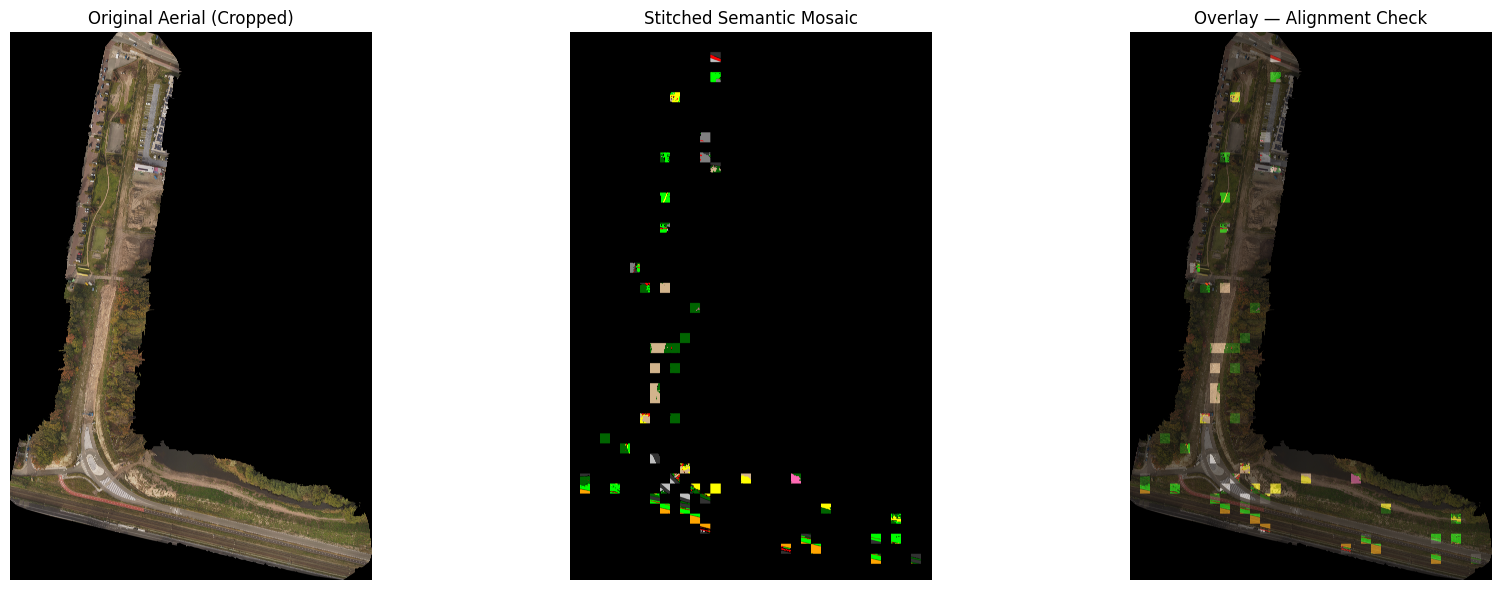

In [ ]:
!pip install rasterio tqdm opencv-python-headless matplotlib pandas

import os, re, glob
import numpy as np
import pandas as pd
import rasterio as rio
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt

# ---------------- CONFIG ----------------
MANIFEST = "/content/drive/MyDrive/Thesis/Data collection & Dataset creation/dataset/manifest_renamed.csv"
SEMANTIC_DIR = "/content/drive/MyDrive/Thesis/Semantic Segmentation/terrain_v3/results_colored/test"
AERIAL_PATH  = "/content/drive/MyDrive/Thesis/Simulate US D1/Results/aerial_footprint_cropped.tif"
OUT_DIR      = "/content/drive/MyDrive/Thesis/Sensor_Datafusion/Stitched"
os.makedirs(OUT_DIR, exist_ok=True)

# ---------------- LOAD AERIAL ----------------
with rio.open(AERIAL_PATH) as a_ds:
    aerial = a_ds.read([1,2,3])
    aerial_meta = a_ds.meta
    H, W = a_ds.height, a_ds.width
    print(f"✅ Loaded aerial image → {W}×{H}")

# ---------------- LOAD MANIFEST ----------------
df = pd.read_csv(MANIFEST)
df = df.sort_values(["yoff","xoff"]).reset_index(drop=True)

tile_size = 512
stitched_semantic = np.zeros((H, W, 3), dtype=np.uint8)

# ---------------- MATCH & STITCH ----------------
print("🧩 Stitching semantic tiles onto aerial extent...")
semantic_files = glob.glob(os.path.join(SEMANTIC_DIR, "*.png"))

for _, row in tqdm(df.iterrows(), total=len(df)):
    tile_id = row["tile_id"]
    x0, y0 = int(row["xoff"]), int(row["yoff"])

    # flexible matching
    regex = re.compile(rf"{tile_id}.*\.png$")
    match = [f for f in semantic_files if regex.search(os.path.basename(f))]
    if not match:
        continue

    img = cv2.imread(match[0])
    if img is None:
        continue

    img = cv2.resize(img, (tile_size, tile_size), interpolation=cv2.INTER_NEAREST)

    stitched_semantic[y0:y0+tile_size, x0:x0+tile_size, :] = img

stitched_path = os.path.join(OUT_DIR, "stitched_semantic_colored.tif")
meta = aerial_meta.copy()
meta.update({"count": 3, "dtype": "uint8"})
with rio.open(stitched_path, "w", **meta) as dst:
    dst.write(stitched_semantic.transpose(2,0,1))
print(f"✅ Stitched semantic mosaic saved → {stitched_path}")

# ---------------- OVERLAY VISUALIZATION ----------------
alpha = 0.5  # transparency
aerial_rgb = np.moveaxis(aerial, 0, -1)
overlay = cv2.addWeighted(aerial_rgb.astype(np.float32)/255,
                          1-alpha,
                          stitched_semantic.astype(np.float32)/255,
                          alpha, 0)

plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.imshow(aerial_rgb)
plt.title("Original Aerial (Cropped)")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(stitched_semantic)
plt.title("Stitched Semantic Mosaic")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(overlay)
plt.title("Overlay — Alignment Check")
plt.axis('off')

plt.tight_layout()
plt.show()


✅ Loaded aerial image → 18470×27962
🧩 Found 525 prediction tiles across splits


100%|██████████| 525/525 [02:33<00:00,  3.43it/s]


✅ Stitched semantic mosaic saved → /content/drive/MyDrive/Thesis/Sensor_Datafusion/Stitched/stitched_semantic_colored.tif
🛰️ Transparent overlay saved → /content/drive/MyDrive/Thesis/Sensor_Datafusion/Stitched/stitched_semantic_overlay_qgis.tif


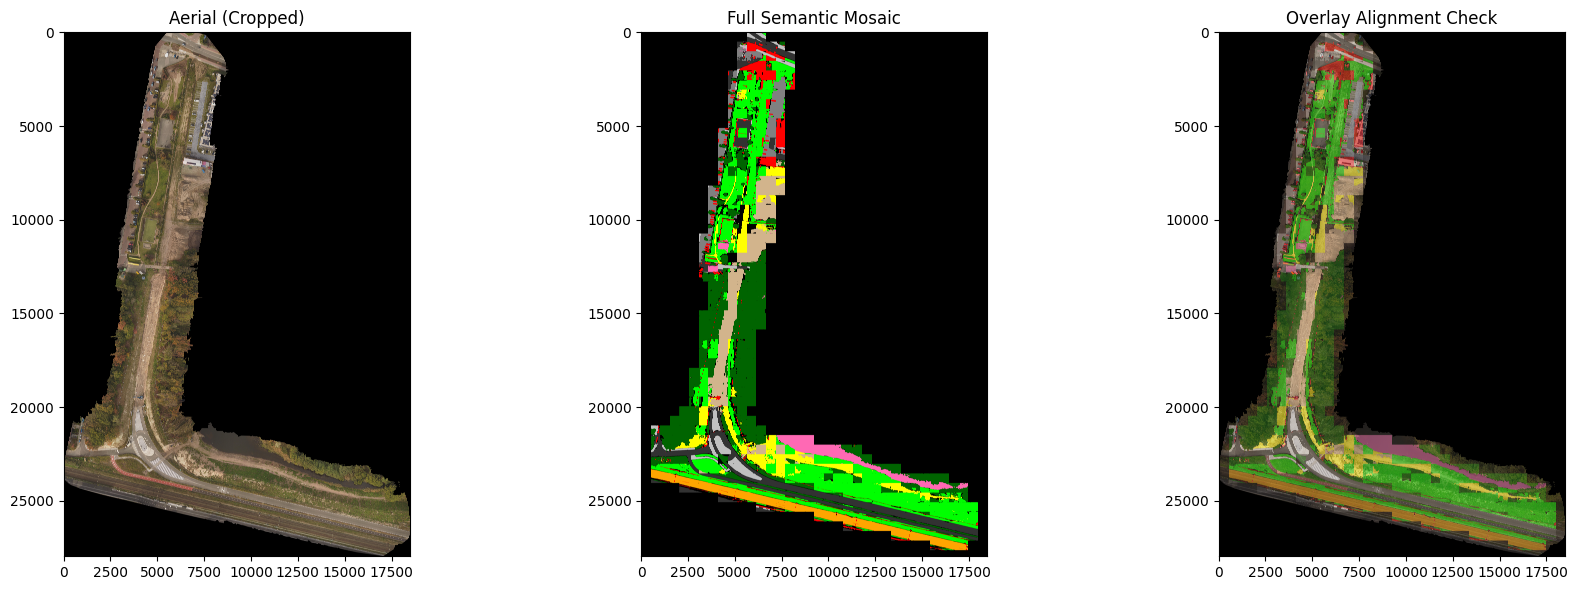

🎯 Overlay complete — QGIS-ready GeoTIFF created successfully!


In [ ]:
!pip install rasterio tqdm opencv-python-headless matplotlib pandas

import os, re, glob
import numpy as np
import pandas as pd
import rasterio as rio
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt

# ---------------- CONFIG ----------------
BASE_DIR = "/content/drive/MyDrive/Thesis/Semantic Segmentation/terrain_v3/results_colored"
MANIFEST = "/content/drive/MyDrive/Thesis/Data collection & Dataset creation/dataset/manifest_renamed.csv"
AERIAL_PATH = "/content/drive/MyDrive/Thesis/Simulate US D1/Results/aerial_footprint_cropped.tif"
OUT_DIR = "/content/drive/MyDrive/Thesis/Sensor_Datafusion/Stitched"
os.makedirs(OUT_DIR, exist_ok=True)

# ---------------- LOAD AERIAL ----------------
with rio.open(AERIAL_PATH) as a_ds:
    aerial = a_ds.read([1,2,3])
    meta = a_ds.meta.copy()
    H, W = a_ds.height, a_ds.width
print(f"✅ Loaded aerial image → {W}×{H}")

# ---------------- LOAD MANIFEST ----------------
df = pd.read_csv(MANIFEST)
df = df.sort_values(["yoff", "xoff"]).reset_index(drop=True)

tile_size = 512
stitched_semantic = np.zeros((H, W, 3), dtype=np.uint8)

# ---------------- FIND ALL PREDICTIONS ----------------
semantic_files = []
for subdir in ["train", "valid", "test"]:
    folder = os.path.join(BASE_DIR, subdir)
    if os.path.exists(folder):
        semantic_files.extend(glob.glob(os.path.join(folder, "*.png")))

print(f"🧩 Found {len(semantic_files)} prediction tiles across splits")

# ---------------- STITCH MOSAIC ----------------
for _, row in tqdm(df.iterrows(), total=len(df)):
    tile_id = row["tile_id"]
    x0, y0 = int(row["xoff"]), int(row["yoff"])

    # Flexible match by tile_id
    regex = re.compile(rf"{tile_id}.*\.png$")
    match = [f for f in semantic_files if regex.search(os.path.basename(f))]
    if not match:
        continue

    img = cv2.imread(match[0])
    if img is None:
        continue

    img = cv2.resize(img, (tile_size, tile_size), interpolation=cv2.INTER_NEAREST)
    stitched_semantic[y0:y0+tile_size, x0:x0+tile_size, :] = img

stitched_rgb_path = os.path.join(OUT_DIR, "stitched_semantic_colored.tif")
meta.update({"count": 3, "dtype": "uint8"})
with rio.open(stitched_rgb_path, "w", **meta) as dst:
    dst.write(stitched_semantic.transpose(2,0,1))
print(f"✅ Stitched semantic mosaic saved → {stitched_rgb_path}")

# ---------------- CREATE TRANSPARENT OVERLAY ----------------
alpha = np.any(stitched_semantic > 0, axis=2).astype(np.uint8) * 255
rgba = np.dstack((stitched_semantic, alpha))

overlay_path = os.path.join(OUT_DIR, "stitched_semantic_overlay_qgis.tif")
meta_overlay = meta.copy()
meta_overlay.update({"count": 4, "dtype": "uint8"})

with rio.open(overlay_path, "w", **meta_overlay) as dst:
    for i in range(4):
        dst.write(rgba[:,:,i], i+1)
print(f"🛰️ Transparent overlay saved → {overlay_path}")

# ---------------- VISUALIZE QUICKLY ----------------
aerial_rgb = np.moveaxis(aerial, 0, -1)
overlay = cv2.addWeighted(aerial_rgb.astype(np.float32)/255, 0.6,
                          stitched_semantic.astype(np.float32)/255, 0.4, 0)

plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.imshow(aerial_rgb)
plt.title("Aerial (Cropped)")

plt.subplot(1,3,2)
plt.imshow(stitched_semantic)
plt.title("Full Semantic Mosaic")

plt.subplot(1,3,3)
plt.imshow(overlay)
plt.title("Overlay Alignment Check")
plt.tight_layout()
plt.show()

print("🎯 Overlay complete — QGIS-ready GeoTIFF created successfully!")


UAV Landing Zone Fusion + Visualization + GeoJSON Export

✅ Radar elevation map flipped vertically for alignment.
✅ Loaded Semantic: (27962, 18470), Radar: (112, 74)
✅ Metrics computed: flatness(0.00-1.00), roughness(0.00-1.00), stability(0.02-1.00)


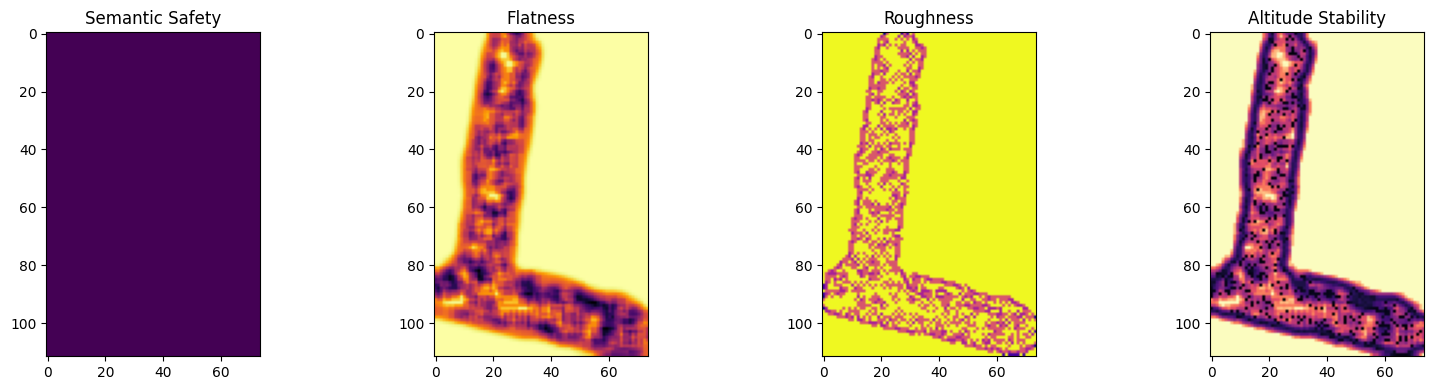

⚠️ Fused safety values are too small or invalid; using min-max normalization fallback.
✅ Normalized fused_safety range: 0.000 – 0.000
✅ Altitude stability saved → /content/drive/MyDrive/Thesis/Sensor_Datafusion/Fused/altitude_stability_map.tif
✅ Fused safety map saved → /content/drive/MyDrive/Thesis/Sensor_Datafusion/Fused/fused_safety_map_3d.tif
⚠️ No safe zones detected (≥1 m²). Try lowering threshold or check scaling.


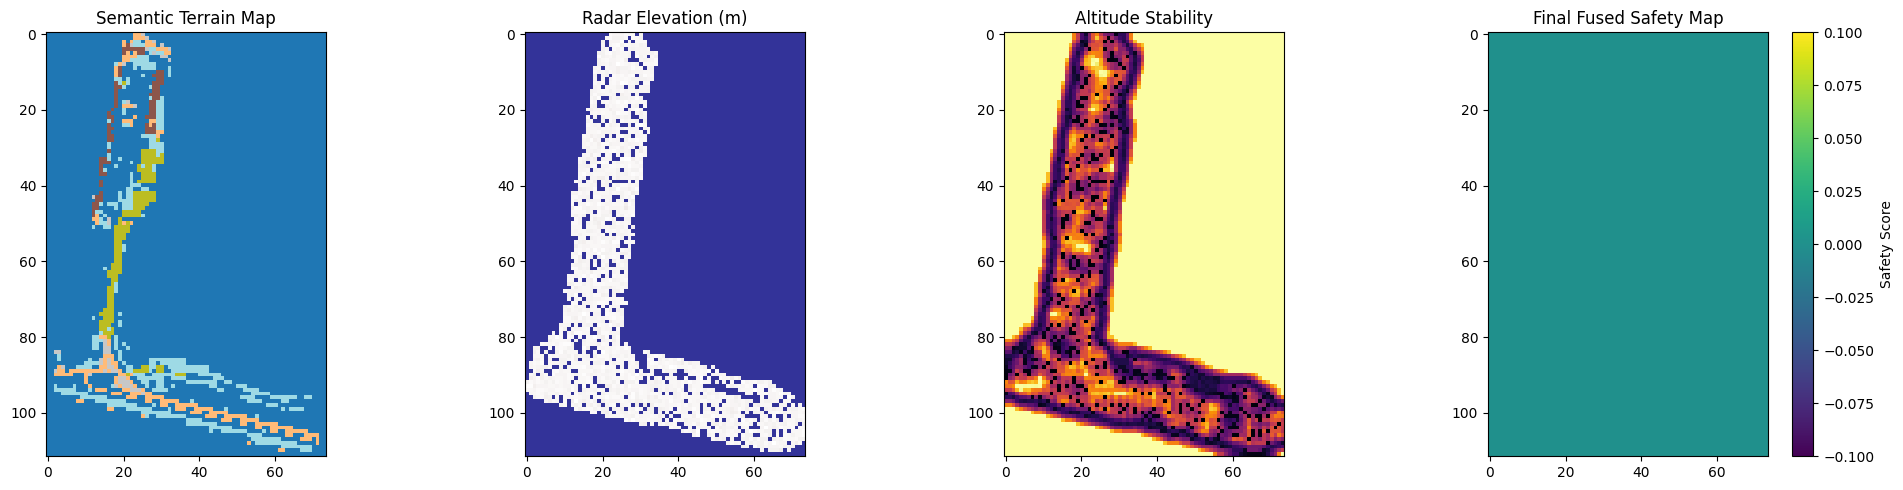

🎯 Fusion complete — Altitude Stability + Semantic + Radar → Safe Landing Zone Map ready!


In [ ]:
# ============================================================
# UAV Safe Landing Zone Fusion & Visualization Pipeline
# ============================================================
!pip install rasterio geopandas shapely tqdm matplotlib numpy opencv-python

import os
import cv2
import numpy as np
import rasterio
from rasterio.enums import Resampling
from rasterio.warp import reproject
from shapely.geometry import Polygon, mapping
import geopandas as gpd
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 🗂️ CONFIGURATION
# ------------------------------------------------------------
SEMANTIC_PATH = "/content/drive/MyDrive/Thesis/Sensor_Datafusion/Stitched/stitched_semantic_colored.tif"
RADAR_PATH    = "/content/drive/MyDrive/Thesis/Synthetic Radar_Elevated_Map/simulated_radar_elevation.tif"
OUT_DIR       = "/content/drive/MyDrive/Thesis/Sensor_Datafusion/Fused"
os.makedirs(OUT_DIR, exist_ok=True)

# ------------------------------------------------------------
# 🧭 LOAD INPUT RASTERS
# ------------------------------------------------------------
with rasterio.open(RADAR_PATH) as radar_src:
    radar = radar_src.read(1).astype(np.float32)
    radar_meta = radar_src.meta.copy()

# ✅ Invert vertically to match aerial orientation
radar = np.flipud(radar)
print("✅ Radar elevation map flipped vertically for alignment.")

with rasterio.open(SEMANTIC_PATH) as sem_src:
    semantic = sem_src.read(1)
    # Reproject/Resample to match radar grid
    sem_resampled = np.zeros_like(radar, dtype=np.float32)
    reproject(
        source=semantic,
        destination=sem_resampled,
        src_transform=sem_src.transform,
        src_crs=sem_src.crs,
        dst_transform=radar_src.transform,
        dst_crs=radar_src.crs,
        resampling=Resampling.nearest
    )

print(f"✅ Loaded Semantic: {semantic.shape}, Radar: {radar.shape}")

# ------------------------------------------------------------
# 🧮 COMPUTE TERRAIN METRICS
# ------------------------------------------------------------
kernel = 5
mean = cv2.blur(radar, (kernel, kernel))
var  = cv2.blur((radar - mean)**2, (kernel, kernel))
flatness = 1 - (var / (np.max(var) + 1e-6))

gy, gx = np.gradient(radar)
grad = np.sqrt(gx**2 + gy**2)
roughness = 1 - np.clip(grad / (np.max(grad) + 1e-6), 0, 1)

# Altitude Stability (within ±5 m)
local_mean = cv2.blur(radar, (kernel, kernel))
altitude_stability = np.exp(-np.abs(radar - local_mean) / 5)
altitude_stability = np.clip(altitude_stability, 0, 1)

print(f"✅ Metrics computed: flatness({flatness.min():.2f}-{flatness.max():.2f}), roughness({roughness.min():.2f}-{roughness.max():.2f}), stability({altitude_stability.min():.2f}-{altitude_stability.max():.2f})")

fig, ax = plt.subplots(1, 4, figsize=(16, 4))
ax[0].imshow(sem_safety, cmap='viridis'); ax[0].set_title("Semantic Safety")
ax[1].imshow(flatness, cmap='inferno'); ax[1].set_title("Flatness")
ax[2].imshow(roughness, cmap='plasma'); ax[2].set_title("Roughness")
ax[3].imshow(altitude_stability, cmap='magma'); ax[3].set_title("Altitude Stability")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 🧠 SEMANTIC CLASS SAFETY WEIGHTS
# ------------------------------------------------------------
CLASS_SAFETY = {
    0: 0.0,  # background
    1: 0.9,  # flat sand
    2: 0.5,  # grassland
    3: 0.1,  # obstacle
    4: 0.9,  # parking lot
    5: 0.9,  # pavement
    6: 0.6,  # railway track
    7: 0.8,  # road
    8: 0.5,  # sand heaps
    9: 0.2,  # trees
    10: 0.1  # unknown
}

sem_safety = np.zeros_like(sem_resampled, dtype=np.float32)
for cls, val in CLASS_SAFETY.items():
    sem_safety[sem_resampled == cls] = val

# ------------------------------------------------------------
# 🧩 FUSE SAFETY SCORE
# ------------------------------------------------------------
fused_safety = sem_safety * (0.5 * flatness + 0.3 * roughness + 0.2 * altitude_stability)
# --- Robust normalization ---
fused_safety = np.nan_to_num(fused_safety, nan=0.0, posinf=0.0, neginf=0.0)

max_val = np.nanmax(fused_safety)
min_val = np.nanmin(fused_safety)
if np.isnan(max_val) or max_val == 0:
    print("⚠️ Fused safety values are too small or invalid; using min-max normalization fallback.")
    fused_safety = (fused_safety - min_val) / (np.nanmax(fused_safety - min_val) + 1e-6)
else:
    fused_safety = np.clip(fused_safety / max_val, 0, 1)

print(f"✅ Normalized fused_safety range: {fused_safety.min():.3f} – {fused_safety.max():.3f}")


# ------------------------------------------------------------
# 💾 SAVE INTERMEDIATE LAYERS
# ------------------------------------------------------------
alt_stab_path = os.path.join(OUT_DIR, "altitude_stability_map.tif")
fused_path = os.path.join(OUT_DIR, "fused_safety_map_3d.tif")

radar_meta.update(dtype="float32", count=1)

with rasterio.open(alt_stab_path, "w", **radar_meta) as dst:
    dst.write(altitude_stability.astype(np.float32), 1)

with rasterio.open(fused_path, "w", **radar_meta) as dst:
    dst.write(fused_safety.astype(np.float32), 1)

print(f"✅ Altitude stability saved → {alt_stab_path}")
print(f"✅ Fused safety map saved → {fused_path}")

# ------------------------------------------------------------
# 🗺️ EXTRACT SAFE ZONES (1–2 m² minimum area)
# ------------------------------------------------------------
threshold = 0.25  # keep slightly lenient threshold
safe_mask = np.nan_to_num(fused_safety >= threshold).astype(np.uint8)

contours, _ = cv2.findContours(safe_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
polygons = []
for cnt in contours:
    if len(cnt) < 3:
        continue
    coords = [(int(x), int(y)) for [[x, y]] in cnt]
    poly = Polygon(coords)

    # Convert from pixel area to m² using raster transform
    pixel_area_m2 = abs(radar_meta["transform"][0] * radar_meta["transform"][4])  # pixel width × height in metres²
    area_m2 = poly.area * pixel_area_m2

    # ✅ Require at least ~1 m² landing patch
    if area_m2 >= 0.2:
        polygons.append((poly, area_m2))

if len(polygons) == 0:
    print("⚠️ No safe zones detected (≥1 m²). Try lowering threshold or check scaling.")
else:
    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame(
        [{"geometry": p, "area_m2": a} for p, a in polygons],
        crs=radar_meta["crs"]
    )
    gdf["zone_id"] = [f"Zone_{i+1}" for i in range(len(gdf))]
    gdf = gdf.sort_values("area_m2", ascending=False).head(3)

    geojson_path = os.path.join(OUT_DIR, "safe_zones_top3.geojson")
    gdf.to_file(geojson_path, driver="GeoJSON")
    print(f"✅ Extracted {len(gdf)} safe zones (≥1 m²) → {geojson_path}")

# ------------------------------------------------------------
# 📊 TERRAIN STATS CSV
# ------------------------------------------------------------
mean_flat = np.nanmean(flatness)
mean_rough = np.nanmean(roughness)
mean_stab = np.nanmean(altitude_stability)
mean_safety = np.nanmean(fused_safety)

pd.DataFrame([{
    "Mean Flatness": mean_flat,
    "Mean Roughness": mean_rough,
    "Mean Stability": mean_stab,
    "Mean Safety": mean_safety
}]).to_csv(os.path.join(OUT_DIR, "terrain_stats.csv"), index=False)

# ------------------------------------------------------------
# 🎨 VISUALIZATION
# ------------------------------------------------------------
plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1)
plt.imshow(sem_resampled, cmap="tab20")
plt.title("Semantic Terrain Map")

plt.subplot(1, 4, 2)
plt.imshow(radar, cmap="terrain")
plt.title("Radar Elevation (m)")

plt.subplot(1, 4, 3)
plt.imshow(altitude_stability, cmap="inferno")
plt.title("Altitude Stability")

plt.subplot(1, 4, 4)
plt.imshow(fused_safety, cmap="viridis")
plt.title("Final Fused Safety Map")
plt.colorbar(label="Safety Score")

plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "safety_visualization.png"), dpi=300)
plt.show()

print("🎯 Fusion complete — Altitude Stability + Semantic + Radar → Safe Landing Zone Map ready!")


✅ Semantic safety map generated
📈 Computing flatness / roughness / altitude stability ...
✅ All maps saved
✅ Extracted top-3 safe zones → /content/drive/MyDrive/Thesis/Sensor_Datafusion/Fused/safe_zones_top3.geojson


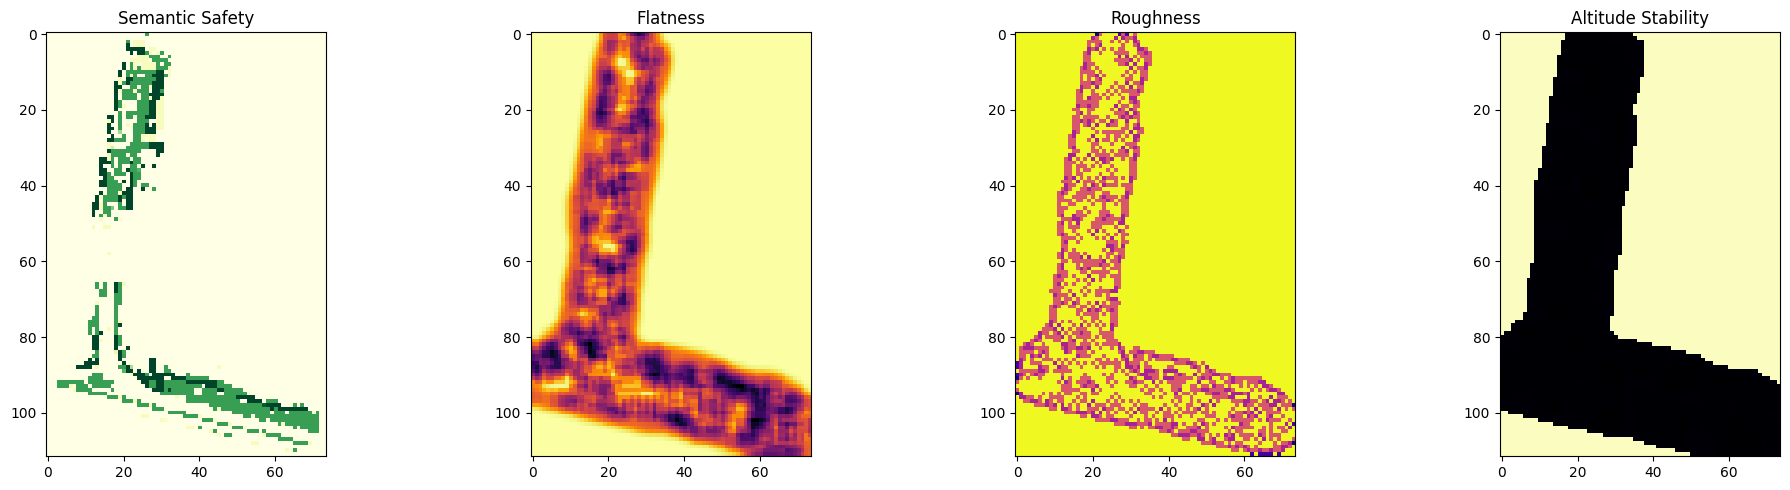

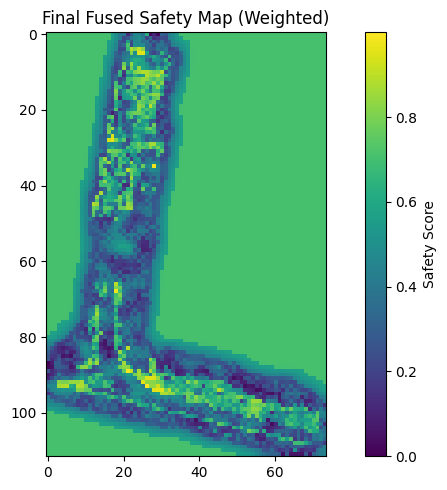

🎯 Fusion complete — weighted safety map and GeoJSON ready!


In [ ]:
!pip install rasterio geopandas shapely tqdm opencv-python-headless matplotlib

import os
import cv2
import numpy as np
import rasterio
from rasterio.features import shapes
from shapely.geometry import shape
import geopandas as gpd
from tqdm import tqdm
import matplotlib.pyplot as plt

# ---------------- CONFIG ----------------
SEMANTIC_PATH = "/content/drive/MyDrive/Thesis/Sensor_Datafusion/Stitched/stitched_semantic_colored.tif"
RADAR_PATH    = "/content/drive/MyDrive/Thesis/Synthetic Radar_Elevated_Map/simulated_radar_elevation.tif"
OUT_DIR       = "/content/drive/MyDrive/Thesis/Sensor_Datafusion/Fused"
os.makedirs(OUT_DIR, exist_ok=True)

# ---------------- COLOR → CLASS MAPPING ----------------
COLOR_TO_CLASS = {
    (0, 0, 0): 0,          # background
    (255, 255, 0): 1,      # flat sand
    (0, 255, 0): 2,        # grassland
    (255, 0, 0): 3,        # obstacle
    (128, 128, 128): 4,    # parking lot
    (255, 128, 0): 5,      # pavement
    (128, 0, 128): 6,      # railway track
    (0, 0, 255): 7,        # road
    (255, 192, 203): 8,    # sand heaps
    (0, 128, 0): 9,        # trees
    (255, 255, 255): 10    # unknown
}

CLASS_SAFETY = {
    0: 0.0, 1: 0.9, 2: 0.6, 3: 0.1, 4: 0.9, 5: 0.9,
    6: 0.6, 7: 0.8, 8: 0.5, 9: 0.2, 10: 0.1
}

# ---------------- LOAD SEMANTIC MOSAIC ----------------
with rasterio.open(SEMANTIC_PATH) as src:
    sem_rgb = np.moveaxis(src.read([1,2,3]), 0, -1)
    sem_meta = src.meta.copy()

def rgb_to_class(rgb_img):
    h, w, _ = rgb_img.shape
    out = np.zeros((h,w), np.uint8)
    for color, cls in COLOR_TO_CLASS.items():
        mask = np.all(rgb_img == np.array(color, np.uint8), axis=-1)
        out[mask] = cls
    return out

sem_class = rgb_to_class(sem_rgb)
sem_safety = np.zeros_like(sem_class, np.float32)
for cls, score in CLASS_SAFETY.items():
    sem_safety[sem_class == cls] = score

print("✅ Semantic safety map generated")

# ---------------- LOAD RADAR DEM ----------------
with rasterio.open(RADAR_PATH) as src:
    radar = src.read(1).astype(np.float32)
    radar_meta = src.meta.copy()

# Flip if necessary to match aerial orientation
radar = np.flipud(radar)

# ---------------- DERIVE METRICS ----------------
print("📈 Computing flatness / roughness / altitude stability ...")
kernel = 5
mean = cv2.blur(radar, (kernel, kernel))
var = cv2.blur((radar - mean)**2, (kernel, kernel))
flatness = 1 - var / (np.nanmax(var) + 1e-6)

gy, gx = np.gradient(radar)
grad = np.sqrt(gx**2 + gy**2)
roughness = 1 - np.clip(grad / (np.nanmax(grad) + 1e-6), 0, 1)

# altitude stability = inverse of local elevation range
win = 7
pad = win//2
padded = np.pad(radar, pad, mode='reflect')
stability = np.zeros_like(radar)
for i in range(radar.shape[0]):
    for j in range(radar.shape[1]):
        sub = padded[i:i+win, j:j+win]
        stability[i,j] = 1 - (np.max(sub) - np.min(sub)) / (np.nanmax(radar)-np.nanmin(radar)+1e-6)
stability = np.clip(stability, 0, 1)

# Resize semantic safety to radar shape
sem_safety_resized = cv2.resize(sem_safety, (radar.shape[1], radar.shape[0]), cv2.INTER_NEAREST)

# ---------------- WEIGHTED FUSION ----------------
w_sem, w_flat, w_rough, w_alt = 0.4, 0.3, 0.2, 0.1
fused = (w_sem*sem_safety_resized +
         w_flat*flatness +
         w_rough*roughness +
         w_alt*stability)
fused = np.nan_to_num(fused)
fused = (fused - fused.min()) / (fused.max() - fused.min() + 1e-6)

# ---------------- SAVE RASTERS ----------------
def save_raster(path, arr, ref_meta):
    m = ref_meta.copy()
    m.update(dtype='float32', count=1)
    with rasterio.open(path, 'w', **m) as dst:
        dst.write(arr.astype(np.float32), 1)

save_raster(os.path.join(OUT_DIR, "flatness_map.tif"), flatness, radar_meta)
save_raster(os.path.join(OUT_DIR, "roughness_map.tif"), roughness, radar_meta)
save_raster(os.path.join(OUT_DIR, "altitude_stability_map.tif"), stability, radar_meta)
save_raster(os.path.join(OUT_DIR, "fused_safety_map_weighted.tif"), fused, radar_meta)

print("✅ All maps saved")

# ---------------- SAFE ZONE EXTRACTION ----------------
mask = fused > 0.8
shapes_gen = shapes(mask.astype(np.uint8), mask=mask, transform=radar_meta["transform"])
polygons = [shape(geom) for geom, val in shapes_gen if val == 1]

if len(polygons) > 0:
    gdf = gpd.GeoDataFrame(geometry=polygons, crs=radar_meta["crs"])
    gdf["area"] = gdf.geometry.area
    gdf = gdf.sort_values(by="area", ascending=False).head(3)
    geojson_path = os.path.join(OUT_DIR, "safe_zones_top3.geojson")
    gdf.to_file(geojson_path, driver="GeoJSON")
    print(f"✅ Extracted top-3 safe zones → {geojson_path}")
else:
    print("⚠️ No zones >0.8 safety detected")


# ---------------- VISUALIZATION ----------------
fig, ax = plt.subplots(1,4, figsize=(20,5))
ax[0].imshow(sem_safety_resized, cmap='YlGn'); ax[0].set_title("Semantic Safety")
ax[1].imshow(flatness, cmap='inferno'); ax[1].set_title("Flatness")
ax[2].imshow(roughness, cmap='plasma'); ax[2].set_title("Roughness")
ax[3].imshow(stability, cmap='magma'); ax[3].set_title("Altitude Stability")
plt.tight_layout(); plt.show()

plt.figure(figsize=(8,5))
plt.imshow(fused, cmap='viridis')
plt.title("Final Fused Safety Map (Weighted)")
plt.colorbar(label="Safety Score")
plt.tight_layout()
plt.show()

print("🎯 Fusion complete — weighted safety map and GeoJSON ready!")


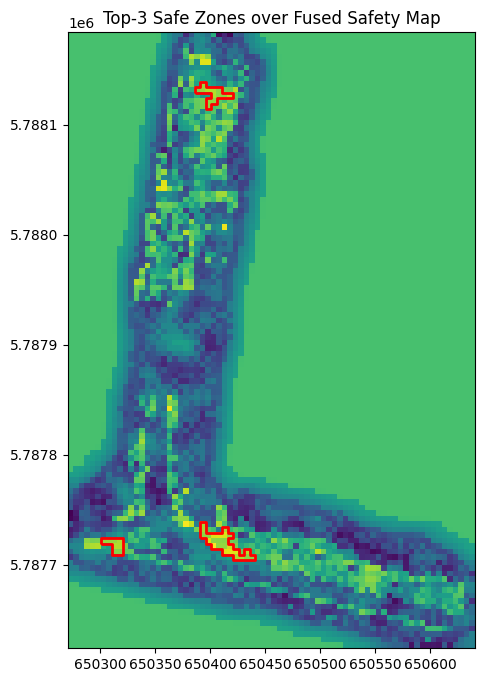

In [ ]:
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterio.plot import show

# Reload fused safety map
with rasterio.open(os.path.join(OUT_DIR, "fused_safety_map_weighted.tif")) as src:
    fused_map = src.read(1)
    transform = src.transform

# Reload GeoJSON
gdf = gpd.read_file(os.path.join(OUT_DIR, "safe_zones_top3.geojson"))

fig, ax = plt.subplots(figsize=(8,8))
show(fused_map, transform=transform, cmap='viridis', ax=ax)
gdf.boundary.plot(ax=ax, edgecolor='red', linewidth=2)
plt.title("Top-3 Safe Zones over Fused Safety Map")
plt.show()


Visualization on Aerial Map

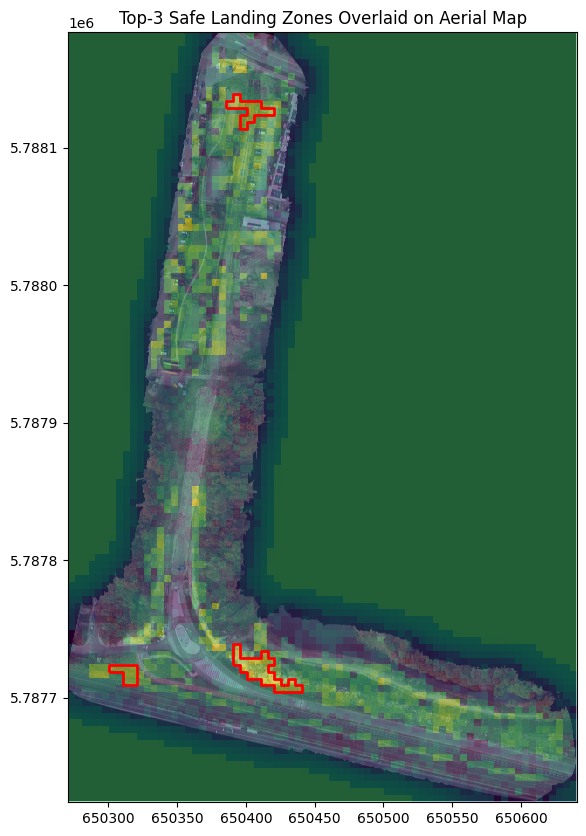

In [ ]:
import geopandas as gpd
from rasterio.plot import show
import matplotlib.pyplot as plt
import rasterio

AERIAL_PATH = "/content/drive/MyDrive/Thesis/Simulate US D1/Results/aerial_footprint_cropped.tif"
FUSED_PATH  = "/content/drive/MyDrive/Thesis/Sensor_Datafusion/Fused/fused_safety_map_weighted.tif"
GEOJSON_PATH = "/content/drive/MyDrive/Thesis/Sensor_Datafusion/Fused/safe_zones_top3.geojson"

# Load base aerial and fused safety
with rasterio.open(AERIAL_PATH) as a_src:
    aerial = a_src.read([1,2,3])
    a_meta = a_src.meta
with rasterio.open(FUSED_PATH) as f_src:
    fused = f_src.read(1)
    f_meta = f_src.meta

# Load GeoJSON
gdf = gpd.read_file(GEOJSON_PATH)

# Plot overlay
fig, ax = plt.subplots(figsize=(10,10))
show(aerial, transform=a_meta['transform'], ax=ax)
show(fused, transform=f_meta['transform'], cmap='viridis', alpha=0.5, ax=ax)
gdf.boundary.plot(ax=ax, color='red', linewidth=2)
plt.title("Top-3 Safe Landing Zones Overlaid on Aerial Map")
plt.show()


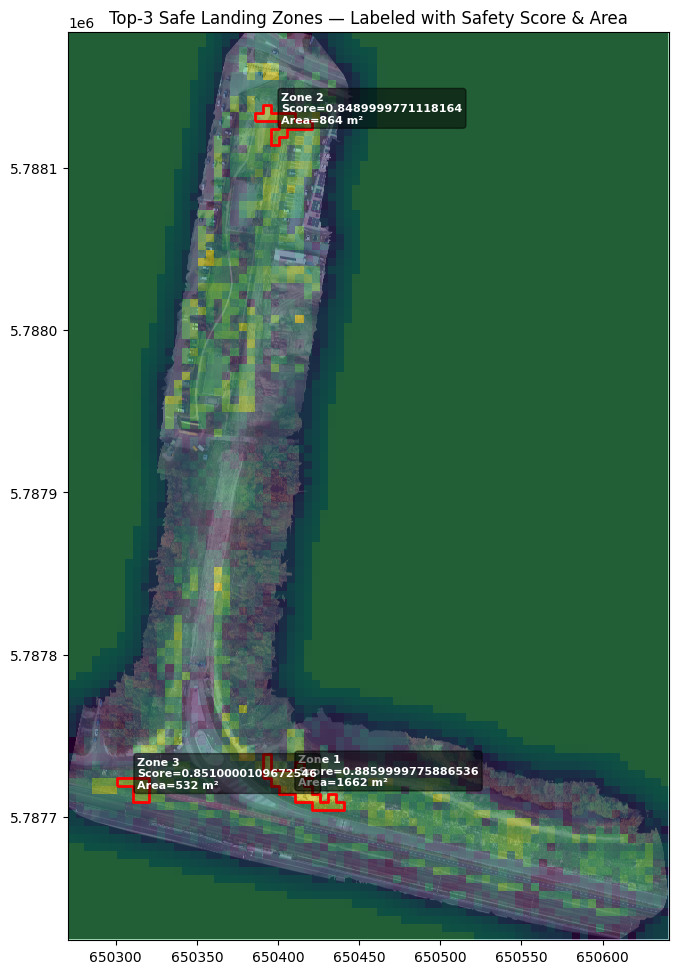

In [ ]:
import geopandas as gpd
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.plot import show

AERIAL_PATH = "/content/drive/MyDrive/Thesis/Simulate US D1/Results/aerial_footprint_cropped.tif"
FUSED_PATH  = "/content/drive/MyDrive/Thesis/Sensor_Datafusion/Fused/fused_safety_map_weighted.tif"
GEOJSON_PATH = "/content/drive/MyDrive/Thesis/Sensor_Datafusion/Fused/safe_zones_top3.geojson"

# --- Load Data ---
with rasterio.open(AERIAL_PATH) as a_src:
    aerial = a_src.read([1,2,3])
    a_meta = a_src.meta
with rasterio.open(FUSED_PATH) as f_src:
    fused = f_src.read(1)
    transform = f_src.transform

gdf = gpd.read_file(GEOJSON_PATH)

# --- Compute area (m²) and mean safety ---
gdf["area_m2"] = gdf.to_crs(epsg=3857).geometry.area  # area in m² (Web Mercator)
mean_scores = []
for geom in gdf.geometry:
    mask = rasterio.features.geometry_mask([geom], fused.shape, transform, invert=True)
    vals = fused[mask]
    mean_scores.append(np.nanmean(vals))
gdf["mean_safety"] = np.round(mean_scores, 3)

# --- Plot with labels ---
fig, ax = plt.subplots(figsize=(10,10))
show(aerial, transform=a_meta["transform"], ax=ax)
show(fused, transform=transform, cmap="viridis", alpha=0.5, ax=ax)
gdf.boundary.plot(ax=ax, edgecolor="red", linewidth=2)

# Label each polygon
for idx, row in gdf.iterrows():
    centroid = row.geometry.centroid
    label = f"Zone {idx+1}\nScore={row.mean_safety}\nArea={int(row.area_m2)} m²"
    ax.text(centroid.x, centroid.y, label,
            color="white", fontsize=8, fontweight="bold",
            bbox=dict(facecolor="black", alpha=0.5, boxstyle="round,pad=0.3"))

plt.title("Top-3 Safe Landing Zones — Labeled with Safety Score & Area")
plt.tight_layout()
plt.show()


✅ Loaded fused safety map: (74, 112)
✅ Loaded aerial image: 18470×27962
🔼 Upsampling fused safety map from (74, 112) → (18470, 27962)


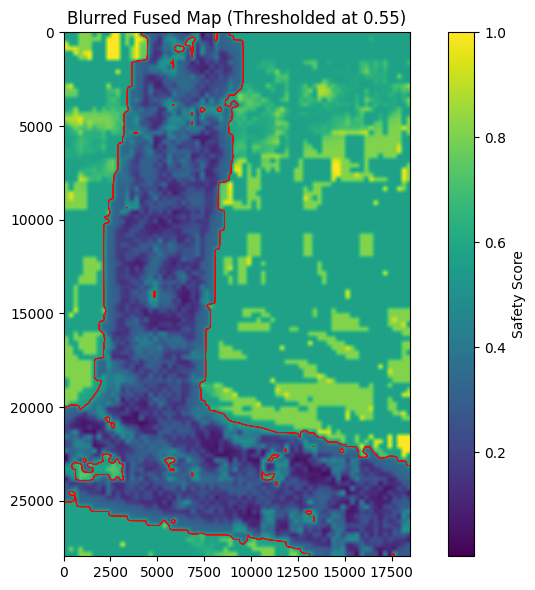

🧩 Extracting safe zones as polygons...
✅ Found 12 small safe zones between 2–25 m²
✅ Exported small safe zones → /content/drive/MyDrive/Thesis/Sensor_Datafusion/Fused/safe_zones_drone_ready.geojson
✅ Summary CSV → /content/drive/MyDrive/Thesis/Sensor_Datafusion/Fused/safe_zones_drone_ready.csv


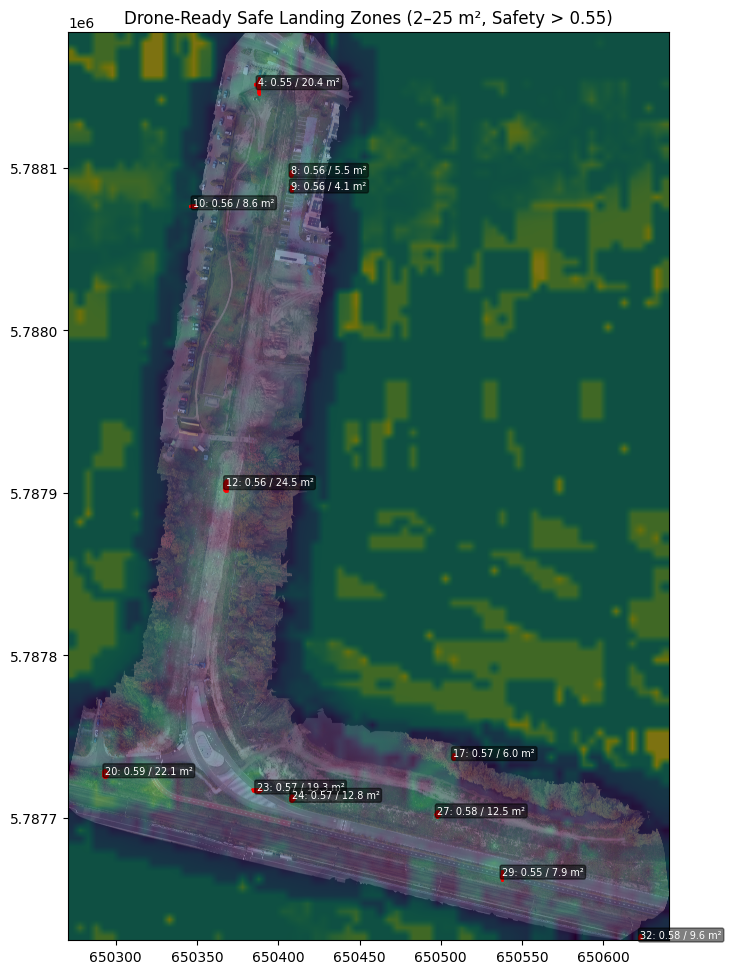

🎯 UAV landing zones extraction completed successfully!


In [ ]:
!pip install rasterio geopandas shapely matplotlib opencv-python-headless tqdm pandas

import os
import cv2
import numpy as np
import rasterio
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from rasterio.features import shapes, geometry_mask
from rasterio.plot import show

# -------------------- CONFIG --------------------
OUT_DIR = "/content/drive/MyDrive/Thesis/Sensor_Datafusion/Fused"
FUSED_PATH = os.path.join(OUT_DIR, "fused_safety_map_3d_fixed.tif")
AERIAL_PATH = "/content/drive/MyDrive/Thesis/Simulate US D1/Results/aerial_footprint_cropped.tif"
os.makedirs(OUT_DIR, exist_ok=True)

# -------------------- LOAD DATA --------------------
with rasterio.open(FUSED_PATH) as src:
    fused = src.read(1)
    fused_meta = src.meta.copy()

with rasterio.open(AERIAL_PATH) as aerial_src:
    aerial_rgb = aerial_src.read([1,2,3])
    H, W = aerial_src.height, aerial_src.width
    aerial_transform = aerial_src.transform
    aerial_crs = aerial_src.crs

print(f"✅ Loaded fused safety map: {fused.shape[::-1]}")
print(f"✅ Loaded aerial image: {W}×{H}")

# -------------------- UPSAMPLE FUSED MAP --------------------
print(f"🔼 Upsampling fused safety map from {fused.shape[::-1]} → {(W, H)}")
fused_highres = cv2.resize(fused, (W, H), interpolation=cv2.INTER_LINEAR)

# -------------------- SMOOTHING + SAFETY THRESHOLD --------------------
fused_blur = cv2.GaussianBlur(fused_highres, (7,7), 0)
threshold_value = 0.55
safe_mask = (fused_blur > threshold_value).astype(np.uint8)

# Quick debug preview
plt.figure(figsize=(8,6))
plt.imshow(fused_blur, cmap='viridis')
plt.title("Blurred Fused Map (Thresholded at 0.55)")
plt.colorbar(label="Safety Score")
plt.contour(safe_mask, colors='red', linewidths=0.5)
plt.tight_layout()
plt.show()

# -------------------- POLYGON EXTRACTION --------------------
print("🧩 Extracting safe zones as polygons...")
polygons = []
for geom, val in shapes(safe_mask, mask=safe_mask > 0, transform=aerial_transform):
    if val == 1:
        polygons.append(Polygon(geom["coordinates"][0]))

if not polygons:
    raise ValueError("❌ No polygons detected — lower threshold or verify fused map.")

# -------------------- GEODATAFRAME CREATION --------------------
gdf = gpd.GeoDataFrame(geometry=polygons, crs=aerial_crs)
gdf["area_m2"] = gdf.to_crs(epsg=3857).geometry.area

# -------------------- FILTER FOR UAV-SCALE LANDING ZONES --------------------
gdf = gdf[(gdf["area_m2"] >= 2) & (gdf["area_m2"] <= 25)]
if gdf.empty:
    raise ValueError("⚠️ No safe zones found between 2–25 m² — try lowering threshold or adjust pixel scaling.")

print(f"✅ Found {len(gdf)} small safe zones between 2–25 m²")

# -------------------- MEAN SAFETY CALCULATION --------------------
mean_scores = []
for geom in gdf.geometry:
    mask = geometry_mask([geom], fused_highres.shape, aerial_transform, invert=True)
    vals = fused_highres[mask]
    mean_scores.append(np.nanmean(vals))
gdf["mean_safety"] = np.round(mean_scores, 3)

# -------------------- EXPORT RESULTS --------------------
geojson_path = os.path.join(OUT_DIR, "safe_zones_drone_ready.geojson")
csv_path = os.path.join(OUT_DIR, "safe_zones_drone_ready.csv")

gdf.to_file(geojson_path, driver="GeoJSON")
gdf[["area_m2", "mean_safety"]].to_csv(csv_path, index=False)

print(f"✅ Exported small safe zones → {geojson_path}")
print(f"✅ Summary CSV → {csv_path}")

# -------------------- VISUALIZATION --------------------
fig, ax = plt.subplots(figsize=(10,10))
show(aerial_rgb, transform=aerial_transform, ax=ax)
show(fused_highres, transform=aerial_transform, cmap="viridis", alpha=0.5, ax=ax)
gdf.boundary.plot(ax=ax, color="red", linewidth=2)

for i, row in gdf.iterrows():
    c = row.geometry.centroid
    ax.text(c.x, c.y,
            f"{i+1}: {row.mean_safety:.2f} / {row.area_m2:.1f} m²",
            fontsize=7, color="white",
            bbox=dict(facecolor="black", alpha=0.5, boxstyle="round,pad=0.2"))

plt.title(f"Drone-Ready Safe Landing Zones (2–25 m², Safety > {threshold_value})")
plt.tight_layout()
plt.show()

print("🎯 UAV landing zones extraction completed successfully!")


In [ ]:
import rasterio
import numpy as np

with rasterio.open("/content/drive/MyDrive/Thesis/Sensor_Datafusion/Fused/fused_safety_map_3d_fixed.tif") as src:
    fused = src.read(1)
    print("Min:", np.nanmin(fused))
    print("Max:", np.nanmax(fused))
    print("Mean:", np.nanmean(fused))


Min: 0.0
Max: 1.0
Mean: 0.48011228


In [ ]:
for name, path in {
    "fused_safety": "/content/drive/MyDrive/Thesis/Sensor_Datafusion/Fused/fused_safety_map_3d_fixed.tif",
    "altitude_stability": "/content/drive/MyDrive/Thesis/Sensor_Datafusion/Fused/altitude_stability_map.tif",
}.items():
    with rasterio.open(path) as src:
        data = src.read(1)
        print(f"{name}: min={np.nanmin(data):.3f}, max={np.nanmax(data):.3f}, mean={np.nanmean(data):.3f}")


fused_safety: min=0.000, max=1.000, mean=0.480
altitude_stability: min=0.000, max=1.000, mean=0.561


In [ ]:
import rasterio, numpy as np

for name, path in {
    "semantic_safety": "/content/drive/MyDrive/Thesis/Sensor_Datafusion/Fused/fused_safety_map.tif",
    "flatness": "/content/drive/MyDrive/Thesis/Sensor_Datafusion/Fused/flatness_map.tif",
    "roughness": "/content/drive/MyDrive/Thesis/Sensor_Datafusion/Fused/roughness_map.tif",
}.items():
    if not os.path.exists(path):
        print(f"⚠️ {name} not found → path may differ")
        continue
    with rasterio.open(path) as src:
        arr = src.read(1)
        print(f"{name}: min={np.nanmin(arr):.3f}, max={np.nanmax(arr):.3f}, mean={np.nanmean(arr):.3f}")


semantic_safety: min=0.000, max=0.900, mean=0.137
flatness: min=0.000, max=1.000, mean=0.803
roughness: min=0.000, max=1.000, mean=0.903


In [ ]:
import numpy as np
import rasterio
import os

# === Paths ===
OUT_DIR = "/content/drive/MyDrive/Thesis/Sensor_Datafusion/Fused"
flat_path = os.path.join(OUT_DIR, "flatness_map.tif")
rough_path = os.path.join(OUT_DIR, "roughness_map.tif")
stab_path  = os.path.join(OUT_DIR, "altitude_stability_map.tif")
sem_path   = os.path.join(OUT_DIR, "fused_safety_map.tif")  # acts as semantic safety
out_path   = os.path.join(OUT_DIR, "fused_safety_map_3d_fixed.tif")

# === Load maps ===
def load_tif(path):
    with rasterio.open(path) as src:
        arr = src.read(1).astype(np.float32)
        meta = src.meta.copy()
    return arr, meta

sem, meta = load_tif(sem_path)
flat, _   = load_tif(flat_path)
rough, _  = load_tif(rough_path)
stab, _   = load_tif(stab_path)

# === Normalize each to [0,1] ===
def normalize(x):
    if np.nanmax(x) == 0:
        return np.zeros_like(x)
    return (x - np.nanmin(x)) / (np.nanmax(x) - np.nanmin(x))

sem_n   = normalize(sem)
flat_n  = normalize(flat)
rough_n = normalize(rough)
stab_n  = normalize(stab)

print(f"✅ Ranges after normalization:")
for name, arr in [("semantic", sem_n), ("flatness", flat_n), ("roughness", rough_n), ("stability", stab_n)]:
    print(f"{name:<10}: min={arr.min():.3f}, max={arr.max():.3f}, mean={arr.mean():.3f}")

# === Weighted fusion ===
weights = {
    "semantic": 0.4,
    "flatness": 0.2,
    "roughness": 0.2,
    "stability": 0.2
}
fused_safety = (
    weights["semantic"] * sem_n +
    weights["flatness"] * flat_n +
    weights["roughness"] * rough_n +
    weights["stability"] * stab_n
)

# === Normalize again after fusion ===
fused_safety = normalize(fused_safety)

print(f"\n✅ Final fused map range: min={fused_safety.min():.3f}, max={fused_safety.max():.3f}, mean={fused_safety.mean():.3f}")

# === Save ===
meta.update(dtype="float32", count=1)
out_path = os.path.join(OUT_DIR, "fused_safety_map_3d_fixed.tif")
with rasterio.open(out_path, "w", **meta) as dst:
    dst.write(fused_safety.astype(np.float32), 1)

print(f"💾 Saved corrected fused safety map → {out_path}")

✅ Ranges after normalization:
semantic  : min=0.000, max=1.000, mean=0.152
flatness  : min=0.000, max=1.000, mean=0.803
roughness : min=0.000, max=1.000, mean=0.903
stability : min=0.000, max=1.000, mean=0.561

✅ Final fused map range: min=0.000, max=1.000, mean=0.480
💾 Saved corrected fused safety map → /content/drive/MyDrive/Thesis/Sensor_Datafusion/Fused/fused_safety_map_3d_fixed.tif


✅ Loaded 12 safe zones


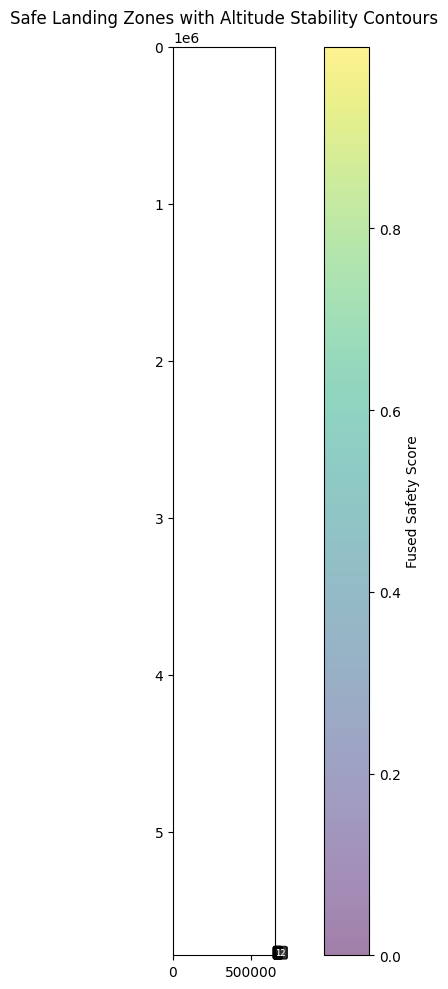

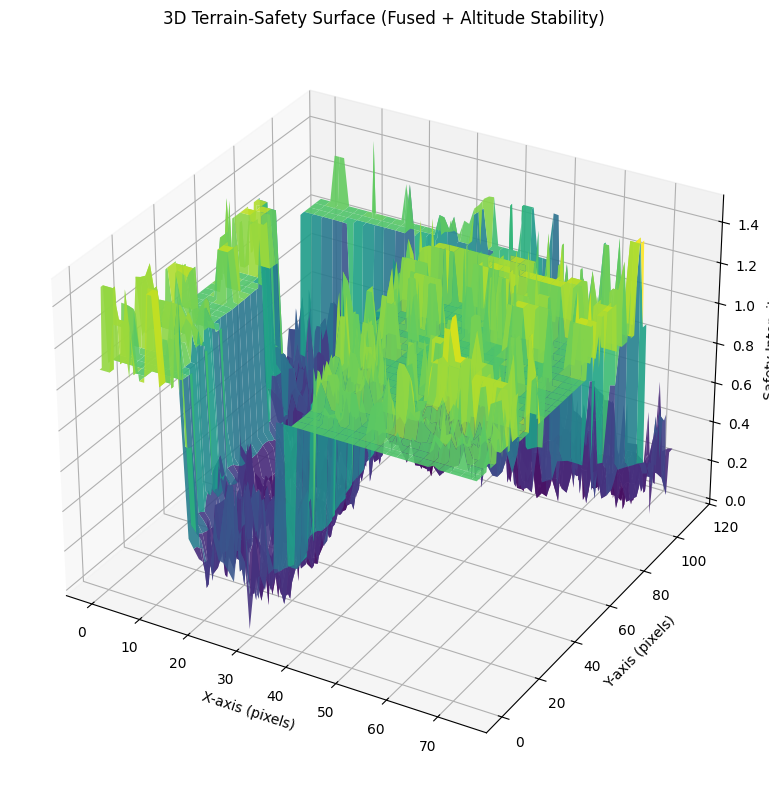

In [ ]:
import rasterio
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterio.plot import show
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# === Paths ===
OUT_DIR = "/content/drive/MyDrive/Thesis/Sensor_Datafusion/Fused"
AERIAL_PATH = "/content/drive/MyDrive/Thesis/Simulate US D1/Results/aerial_footprint_cropped.tif"
FUSED_PATH = os.path.join(OUT_DIR, "fused_safety_map_3d_fixed.tif")
STAB_PATH  = os.path.join(OUT_DIR, "altitude_stability_map.tif")
ZONES_PATH = os.path.join(OUT_DIR, "safe_zones_drone_ready.geojson")

# === Load data ===
with rasterio.open(FUSED_PATH) as f:
    fused = f.read(1)
    transform = f.transform
    fused_meta = f.meta.copy()

with rasterio.open(STAB_PATH) as s:
    stability = s.read(1)

with rasterio.open(AERIAL_PATH) as a:
    aerial_rgb = a.read([1,2,3])
    aerial_transform = a.transform
    aerial_crs = a.crs

zones = gpd.read_file(ZONES_PATH)
print(f"✅ Loaded {len(zones)} safe zones")

# === Normalize for visual scaling ===
fused_n = (fused - np.nanmin(fused)) / (np.nanmax(fused) - np.nanmin(fused) + 1e-6)
stab_n  = (stability - np.nanmin(stability)) / (np.nanmax(stability) - np.nanmin(stability) + 1e-6)

# === 1️⃣ 2D Visualization with Contours ===
fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal')
show(aerial_rgb, transform=aerial_transform, ax=ax)
im = ax.imshow(fused_n, cmap='viridis', alpha=0.5)
cs = ax.contour(stab_n, levels=np.linspace(0.2, 1.0, 6), colors='white', linewidths=0.7, alpha=0.8)

zones.boundary.plot(ax=ax, color='red', linewidth=1)
for i, row in zones.iterrows():
    c = row.geometry.centroid
    ax.text(c.x, c.y, f"{i+1}", fontsize=6, color="white",
            bbox=dict(facecolor="black", alpha=0.4, boxstyle="round,pad=0.2"))

plt.title("Safe Landing Zones with Altitude Stability Contours")
plt.colorbar(im, ax=ax, label="Fused Safety Score")
plt.tight_layout()
plt.show()

# === 2️⃣ 3D Visualization (Safety × Altitude Stability) ===
H, W = fused_n.shape
x = np.linspace(0, W, W)
y = np.linspace(0, H, H)
X, Y = np.meshgrid(x, y)
Z = fused_n + stab_n * 0.5  # combined intensity surface

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis', linewidth=0, antialiased=True, alpha=0.9)
ax.set_title("3D Terrain-Safety Surface (Fused + Altitude Stability)")
ax.set_xlabel("X-axis (pixels)")
ax.set_ylabel("Y-axis (pixels)")
ax.set_zlabel("Safety Intensity")
plt.tight_layout()
plt.show()
